# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

In [3]:
asl.df.describe()

,left-x,left-y,right-x,right-y,nose-x,nose-y
count,15746.000000,15746.000000,15746.000000,15746.000000,15746.000000,15746.000000
mean,187.572082,189.951797,154.567065,132.052394,170.083069,59.330624
std,23.686535,40.534002,17.292290,48.200532,7.328777,4.889615
min,134.000000,70.000000,54.000000,22.000000,140.000000,47.000000
25%,167.000000,167.000000,145.000000,96.000000,164.000000,56.000000
50%,190.000000,185.000000,156.000000,118.000000,171.000000,59.000000
75%,205.000000,237.000000,165.000000,165.000000,175.000000,62.000000
max,290.000000,251.000000,231.000000,251.000000,201.000000,84.000000


In [4]:
asl.df.ix[98,:].describe()

,left-x,left-y,right-x,right-y,nose-x,nose-y
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,165.171717,148.454545,151.212121,116.353535,161.141414,56.777778
std,18.670090,35.910112,14.756716,36.512596,1.659912,2.808717
min,149.000000,90.000000,110.000000,75.000000,159.000000,54.000000
25%,149.000000,117.000000,141.000000,87.500000,159.000000,54.000000
50%,155.000000,172.000000,152.000000,103.000000,161.000000,57.000000
75%,180.000000,181.000000,165.500000,154.500000,162.000000,57.000000
max,206.000000,182.000000,170.000000,175.000000,165.000000,62.000000


##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [5]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [6]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [7]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [8]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [9]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [10]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [11]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [12]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [13]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
features_orig = ['right-x','right-y','left-x','left-y']
for idx_tmp in range(len(features_norm)):
    mean_tmp = asl.df['speaker'].map(df_means[features_orig[idx_tmp]]) # create a temp mean df using i-th original feature
    std_tmp = asl.df['speaker'].map(df_std[features_orig[idx_tmp]]) # create a temp std df using i-th original feature
    # compute i-th normalized feature using Z-score scaling
    asl.df[features_norm[idx_tmp]] = (asl.df[features_orig[idx_tmp]] - mean_tmp)/std_tmp
asl.df[features_norm].head()

norm-rx   norm-ry   norm-lx   norm-ly
video frame                                        
98    0      1.153232  1.663433 -0.891199  0.741835
      1      1.153232  1.663433 -0.891199  0.741835
      2      1.153232  1.663433 -0.891199  0.741835
      3      1.153232  1.663433 -0.891199  0.741835
      4      1.153232  1.663433 -0.891199  0.741835

In [14]:
features_ground

['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']

In [15]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
for idx_tmp in range(0, len(features_polar), 2):
    # calculate corresponding Euclidean norm (radius) for x,y pair
    asl.df[features_polar[idx_tmp]] = np.sqrt(asl.df[features_ground[idx_tmp]]**2 + asl.df[features_ground[idx_tmp+1]]**2)
    # calculate corresponding arctangent (angle) x,y pair
    asl.df[features_polar[idx_tmp+1]] = np.arctan2(asl.df[features_ground[idx_tmp]], asl.df[features_ground[idx_tmp+1]])
asl.df[features_polar].head()   

polar-rr  polar-rtheta    polar-lr  polar-ltheta
video frame                                                   
98    0      113.35784      0.079478  119.603512     -0.100501
      1      113.35784      0.079478  119.603512     -0.100501
      2      113.35784      0.079478  119.603512     -0.100501
      3      113.35784      0.079478  119.603512     -0.100501
      4      113.35784      0.079478  119.603512     -0.100501

In [16]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
asl.df[features_delta] = asl.df[features_orig].diff().fillna(0)
asl.df[features_delta].head()

delta-rx  delta-ry  delta-lx  delta-ly
video frame                                        
98    0           0.0       0.0       0.0       0.0
      1           0.0       0.0       0.0       0.0
      2           0.0       0.0       0.0       0.0
      3           0.0       0.0       0.0       0.0
      4           0.0       0.0       0.0       0.0

In [17]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

#compute min and max dataframes grouped by speaker
df_mins = asl.df.groupby('speaker').min()
df_maxs = asl.df.groupby('speaker').max()

# TODO define a list named 'features_custom' for building the training set
features_custom = ['minmax-rx', 'minmax-ry', 'minmax-lx', 'minmax-ly']
for idx_tmp in range(0, len(features_custom)):
    # create temp min and max dataframes for i-th custom_1 feature using i-th original features
    min_tmp = asl.df['speaker'].map(df_mins[features_orig[idx_tmp]]) 
    max_tmp = asl.df['speaker'].map(df_maxs[features_orig[idx_tmp]])  
    # compute i-th normalized feature using Min-Max scaling in range [0, 1]: (x - min)/ (max - min)
    asl.df[features_custom[idx_tmp]] = (asl.df[features_orig[idx_tmp]] - min_tmp)/(max_tmp - min_tmp)
    
print(asl.df[features_custom].describe())
asl.df[features_custom].head()

          minmax-rx     minmax-ry     minmax-lx     minmax-ly
count  15746.000000  15746.000000  15746.000000  15746.000000
mean       0.536009      0.539893      0.390050      0.756985
std        0.131269      0.237803      0.170322      0.224263
min        0.000000      0.000000      0.000000      0.000000
25%        0.460870      0.357143      0.281250      0.635359
50%        0.550459      0.467249      0.435897      0.871429
75%        0.621469      0.732394      0.474359      0.922652
max        1.000000      1.000000      1.000000      1.000000


minmax-rx  minmax-ry  minmax-lx  minmax-ly
video frame                                            
98    0        0.66087   0.971831   0.104167   0.906542
      1        0.66087   0.971831   0.104167   0.906542
      2        0.66087   0.971831   0.104167   0.906542
      3        0.66087   0.971831   0.104167   0.906542
      4        0.66087   0.971831   0.104167   0.906542

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
My custom features are original values normalized using min-max scaling (rescaled data from the original range to the range of 0 to 1). Min-max scaling helps to get smaller standard deviations (compare to Z-score scaling), helps to suppress the effect of outliers and additionally minimizing speaker dependency. This custom features mostly design to compare which one of the common techniques would be more appropriate for our dataset: MinMax normalization or Z-score standardization.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [18]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.020s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [19]:
# install hmmlearn for python
#!pip install hmmlearn

In [20]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.113812743319


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [21]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [22]:
training.words.index('CHOCOLATE')

58

In [23]:
training.words[57:59]

['BOOK', 'CHOCOLATE']

In [24]:
my_testword = 'CHOCOLATE'
my_testword_list = training.words[57:59] # select some words including CHOCOLATE 
features_list = [features_norm, features_delta, features_polar, features_custom] # list of features to test
features_list_names = ['features_norm', 'features_delta', 'features_polar', 'features_custom'] # names of lists
models_test = {} # dictionary to save results
for word_tmp in my_testword_list:
    features_tmp_dic = {} # temp dictionary to save results for different features
    for idx_features_tmp in range(len(features_list)):
        hidden_tmp_dic = {} # temp dictionary to save results for different number of hidden states
        for hidden_tmp in range(2,5):
            print("\n\nWord: %s \nFeatures: %s \n" % (word_tmp, features_list_names[idx_features_tmp]))
            model, logL = train_a_word(word_tmp, hidden_tmp, features_list[idx_features_tmp]) # Experiment here with different parameters
            show_model_stats(word_tmp, model)
            print("logL = {}".format(logL))
            hidden_tmp_dic[str(hidden_tmp)] = (model, logL)
        features_tmp_dic[features_list_names[idx_features_tmp]] = hidden_tmp_dic 
    models_test[word_tmp] = features_tmp_dic         



Word: BOOK 
Features: features_norm 

Number of states trained in model for BOOK is 2
hidden state #0
mean =  [ 0.58624233 -0.26361779  0.417006   -2.10085337]
variance =  [ 0.18623237  0.02432232  0.14298427  0.09634806]

hidden state #1
mean =  [ 0.81893394 -0.0597661  -0.59093494 -1.77122797]
variance =  [ 0.14778331  0.11736384  0.14185061  0.25084273]

logL = -258.4535818619691


Word: BOOK 
Features: features_norm 

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ 1.16050793 -0.3361429  -0.5022096  -2.22073513]
variance =  [ 0.13396219  0.03829545  0.45021762  0.11123555]

hidden state #1
mean =  [ 0.43609316 -0.22686509  0.39433383 -2.0344738 ]
variance =  [ 0.03713059  0.0184008   0.13829084  0.0787966 ]

hidden state #2
mean =  [ 0.55254803  0.1782496  -0.34612882 -1.39504558]
variance =  [ 0.06906066  0.08221395  0.07482992  0.11132208]

logL = -130.71089221940218


Word: BOOK 
Features: features_norm 

Number of states trained in model for BOOK is 

C:\Anaconda3\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Anaconda3\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Anaconda3\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Anaconda3\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Anaconda3\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),




logL = 22.65197722447521


Word: CHOCOLATE 
Features: features_norm 

Number of states trained in model for CHOCOLATE is 4
hidden state #0
mean =  [ 0.49163141 -0.34766944 -0.19907141 -0.31200148]
variance =  [ 0.02973162  0.00401851  0.00934483  0.2921408 ]

hidden state #1
mean =  [ 0.47581504 -0.25534057 -0.32768595 -1.7243523 ]
variance =  [ 0.042362    0.00442977  0.00152113  0.0066983 ]

hidden state #2
mean =  [ 0.494375    0.05588065  0.10128493 -0.81554085]
variance =  [ 0.05344461  0.02787475  0.01792018  0.07558914]

hidden state #3
mean =  [ 0.9894402  -0.16006052 -1.31412901 -1.55560526]
variance =  [ 0.10711401  0.00555855  0.03518414  0.09325342]

logL = 85.72111948347717


Word: CHOCOLATE 
Features: features_delta 

Number of states trained in model for CHOCOLATE is 2
hidden state #0
mean =  [-0.31854411  1.30980522  0.21263338  0.724708  ]
variance =  [  9.16718655  10.24525841   4.77562231   8.69271558]

hidden state #1
mean =  [  2.83833643  -0.25850626  -0.3939924

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [25]:
%matplotlib inline

In [26]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()


BOOK
features_norm
(GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False), -130.71089221940218)


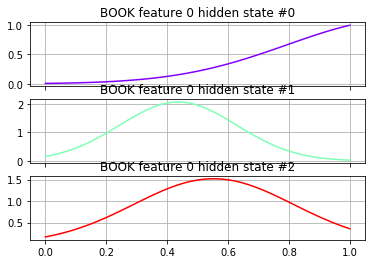

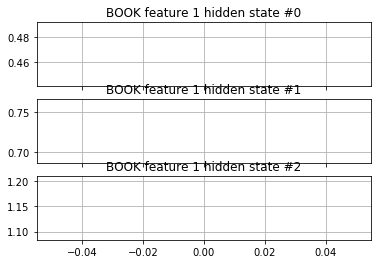

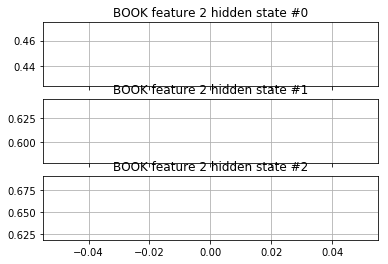

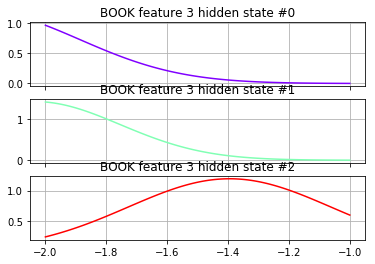

features_delta
(GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False), -663.76956563487374)


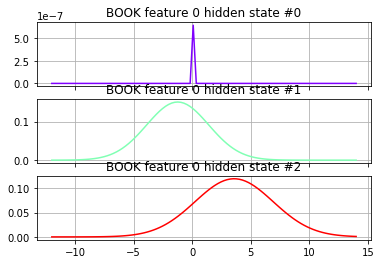

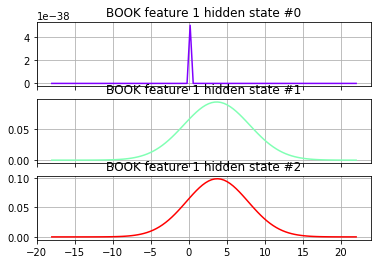

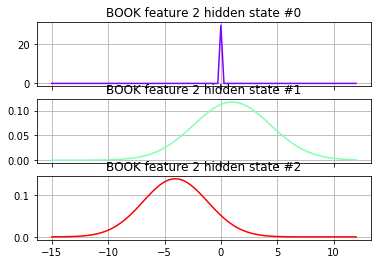

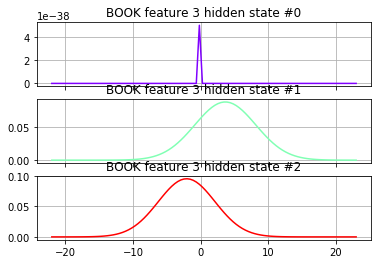

features_polar
(GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False), -901.08441140134812)


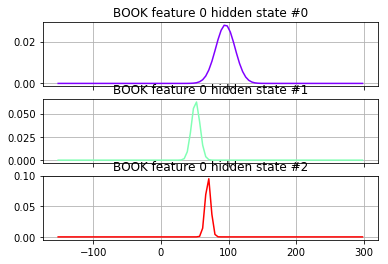

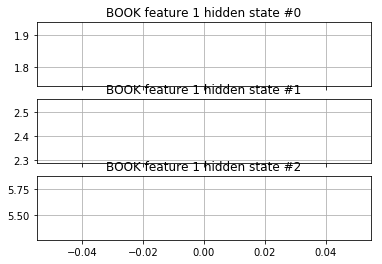

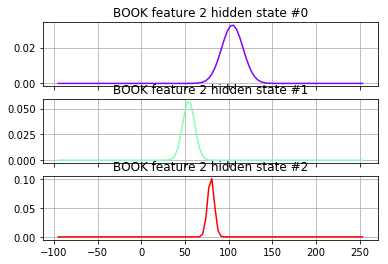

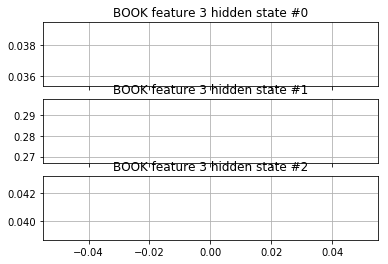

In [27]:
#visualize(my_testword, model)
test_word_tmp = my_testword_list[0]
print(test_word_tmp)
for feature_name_tmp in features_list_names[:3]:
    print(feature_name_tmp)
    print(models_test[test_word_tmp][feature_name_tmp]['3'])
    visualize(test_word_tmp, models_test[test_word_tmp][feature_name_tmp]['3'][0])

#####  ModelSelector class
Review the `SelectorModel` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

Word: VEGETABLE 
Features: features_ground
Number of states trained in model for VEGETABLE is 3


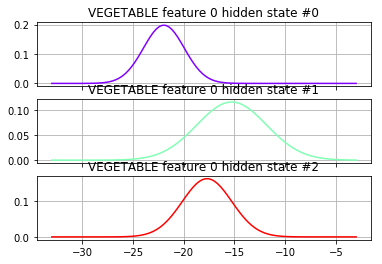

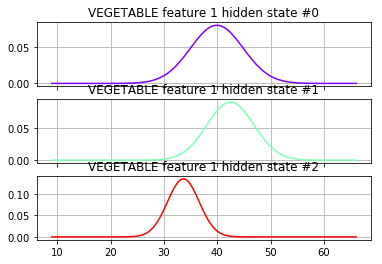

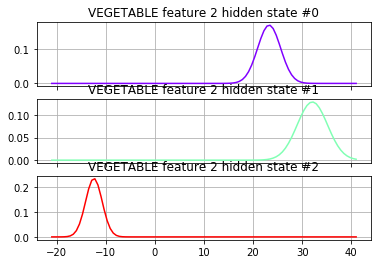

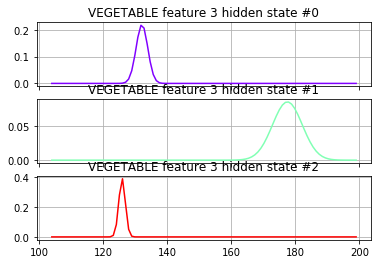

Word: VEGETABLE 
Features: features_delta
Number of states trained in model for VEGETABLE is 3


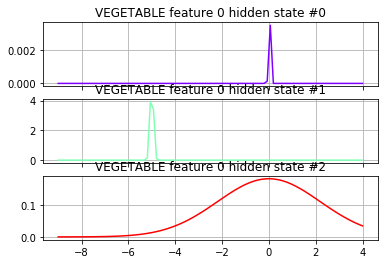

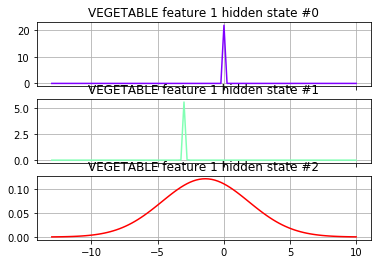

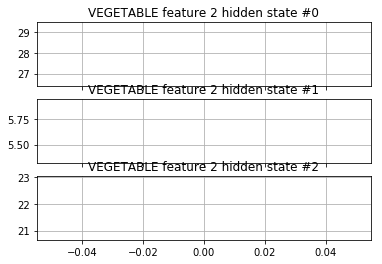

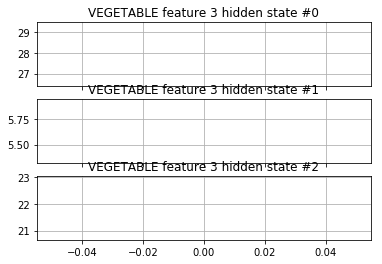

Word: VEGETABLE 
Features: features_polar
Number of states trained in model for VEGETABLE is 3


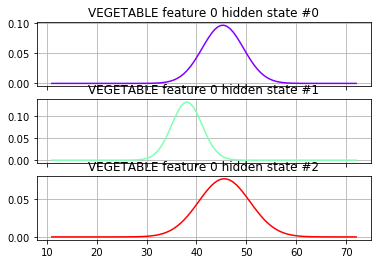

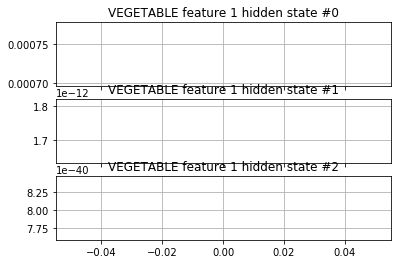

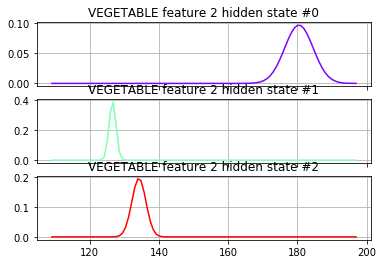

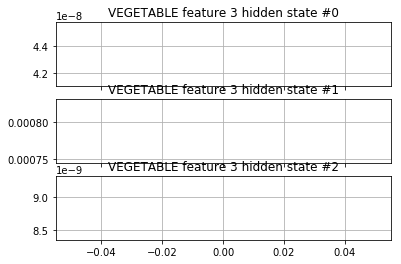

Word: CHOCOLATE 
Features: features_ground
Number of states trained in model for CHOCOLATE is 3


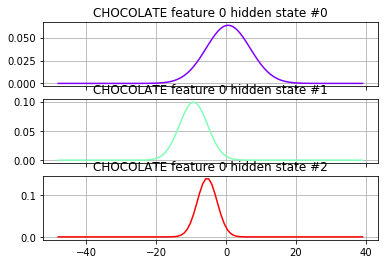

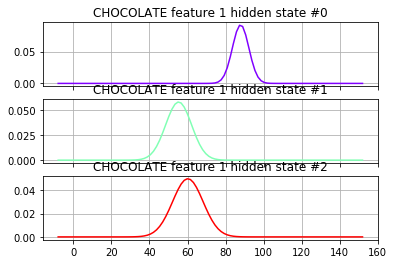

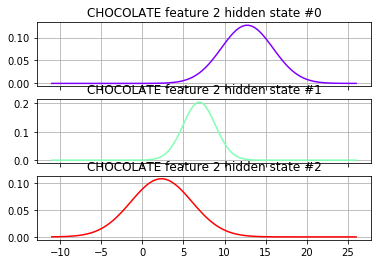

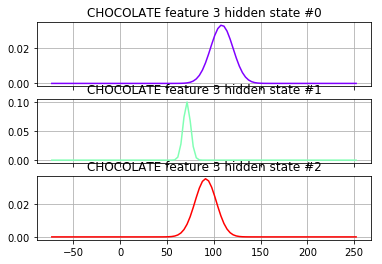

Word: CHOCOLATE 
Features: features_delta
Number of states trained in model for CHOCOLATE is 3


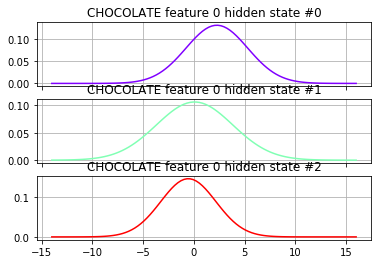

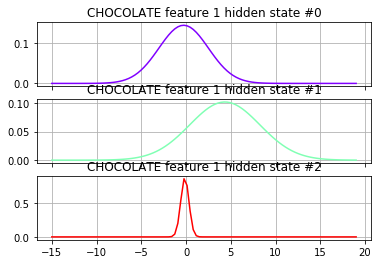

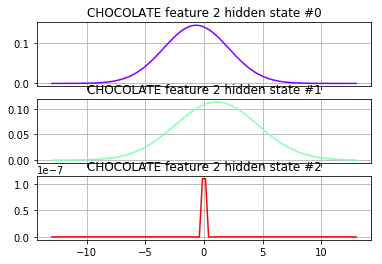

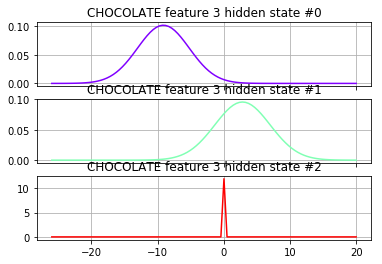

Word: CHOCOLATE 
Features: features_polar
Number of states trained in model for CHOCOLATE is 3


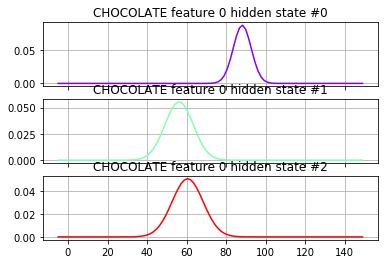

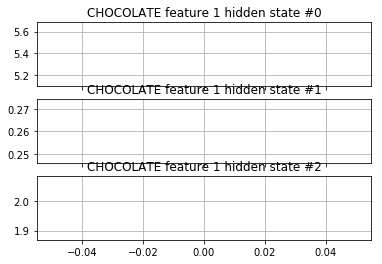

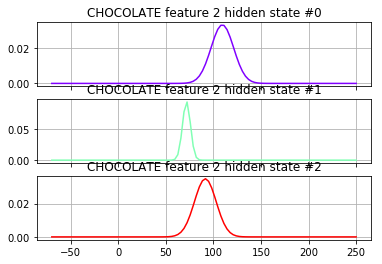

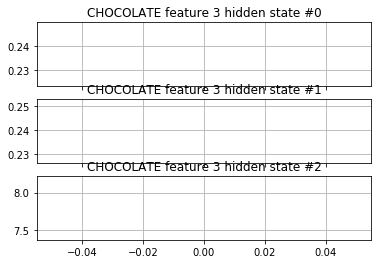

In [28]:
from my_model_selectors import SelectorConstant
features_test2 = [features_ground, features_delta, features_polar]
features_test2_names = ['features_ground', 'features_delta', 'features_polar']
words_test2 = ['VEGETABLE', 'CHOCOLATE'] # Experiment here with different words
for word_tmp in words_test2:
    for features_idx_tmp in range(len(features_test2)):  
        training = asl.build_training(features_test2[features_idx_tmp])  # Experiment here with different feature sets defined in part 1
        model_tmp = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word_tmp, n_constant=3).select()
        print("Word: %s \nFeatures: %s" % (word_tmp, features_test2_names[features_idx_tmp]))
        print("Number of states trained in model for {} is {}".format(word_tmp, model_tmp.n_components))
        visualize(word_tmp, model_tmp)

##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [29]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [30]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [31]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [32]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        X_tmp, length_tmp = training.get_word_Xlengths(word)
        print("Training complete for {} with {} states with time {} seconds. LogL = {}".format(word, model.n_components, end, 
                                                                                               model.score(X_tmp, length_tmp)))

        #print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Best mean CV score:-82020.573489623 for FISH
Training complete for FISH with 11 states with time 0.4720072754654129 seconds. LogL = -73244.14740366442
Best mean CV score:-872.1815845257873 for BOOK
Training complete for BOOK with 6 states with time 4.313211235410847 seconds. LogL = -2270.0455344286756
Best mean CV score:-733.1029806649711 for VEGETABLE
Training complete for VEGETABLE with 2 states with time 1.79334731063385 seconds. LogL = -993.0672787556415
Best mean CV score:-823.6223257212738 for FUTURE
Training complete for FUTURE with 2 states with time 4.200629966178726 seconds. LogL = -2233.795534992241
Best mean CV score:-6466.759088373435 for JOHN
Training complete for JOHN with 12 states with time 42.20061890443722 seconds. LogL = -17872.69072109327


In [33]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        X_tmp, length_tmp = training.get_word_Xlengths(word)
        print("Training complete for {} with {} states with time {} seconds. LogL = {}".format(word, model.n_components, end, 
                                                                                               model.score(X_tmp, length_tmp)))
    else:
        print("Training failed for {}".format(word))

Best BIC score:406.07340519052707 for FISH
Training complete for FISH with 3 states with time 0.40082891950093824 seconds. LogL = 38.49538851118036
Best BIC score:8513.107977878853 for BOOK
Training complete for BOOK with 2 states with time 2.184662737378062 seconds. LogL = -2478.094647200379
Best BIC score:3391.627084162248 for VEGETABLE
Training complete for VEGETABLE with 2 states with time 0.7537391649254346 seconds. LogL = -977.3211052921802
Best BIC score:7020.256218113844 for FUTURE
Training complete for FUTURE with 2 states with time 2.348367820287791 seconds. LogL = -2107.1546801347113
Best BIC score:71226.93372592673 for JOHN
Training complete for JOHN with 2 states with time 21.886753446028777 seconds. LogL = -18764.541702787654


In [34]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        X_tmp, length_tmp = training.get_word_Xlengths(word)
        print("Training complete for {} with {} states with time {} seconds. LogL = {}".format(word, model.n_components, end, 
                                                                                               model.score(X_tmp, length_tmp)))
    else:
        print("Training failed for {}".format(word))

Best DIC score:22781957.80925553 for FISH
Training complete for FISH with 3 states with time 0.9858492671793755 seconds. LogL = 38.49538851118036
Best DIC score:3567.6215998426774 for BOOK
Training complete for BOOK with 15 states with time 4.348145795333295 seconds. LogL = -1777.6673753892178
Best DIC score:61692.81820943333 for VEGETABLE
Training complete for VEGETABLE with 15 states with time 3.0650979536963376 seconds. LogL = -86.33950587211298
Best DIC score:2872.4335190379925 for FUTURE
Training complete for FUTURE with 15 states with time 4.440149854992427 seconds. LogL = -1408.244552375026
Best DIC score:-14012.583417914017 for JOHN
Training complete for JOHN with 15 states with time 26.315298744057785 seconds. LogL = -15359.83425869478


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

All three models, BIC, DIC and CV are useful for ASL modelling. Below are some advantages and disadvantages of the models with models performance highlighting’s.

**Cross Validation**: The k-fold cross-validation is a common technique in machine learning.  This model is the longest to train model and very good for generalization. In fact, the long training-validation time comes from the idea of training and validate model k times, thus the time increase depend on k-fold chosen. On the other hand, the main advantage of k-fold CV is that the train and validation of the model are done on the same dataset instead of splitting dataset to train and validation, which is very critical in case of not enough data available for train/validation splitting. It is worth to mention that CV model use mean log likelihood of validation portion of CV to estimate model performance, which may not be the best scoring function for ASL models.

**Bayesian Information Criterion**:  BIC model is a model which scoring fitting of the word of interest using log likelihood with a penalty term, which have to give the best balance between model fit and model complexity, thus helping to avoid overfitting. This was the fastest model to train (penalty term computing is cheap). At the same time it looks like that BIC models are the most conservative models in terms of final number of states for the best fit. Best models are 2 or 3 states models, thus the final models may be biased compare to CV models.

**Discriminative Information Criterion**:  DIC scores are calculated using log likelihood of the word of interest with penalty coming from dissimilarity of log likelihoods of all other word in the dataset, thus increasing discrimination between modeled word score and the rest of the corpus scores. BIC calculation is slightly longer than AIC due to the penalty calculations have to compute log likelihood for all word. This model is less biased than AIC. On the other have it tends to overfit due to most of the best models have 15 states in them, and tend to work very well on training dataset, not on the unknown ones.


<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [35]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

Best BIC score:1811.7969329347852 for FRANK


.

Best BIC score:2275.882616841791 for VEGETABLE


..

Best mean CV score:-2907.750825782348 for JOHN
Best mean CV score:-218.38956169006354 for CHICKEN
Best DIC score:-2400.286323408547 for MARY


.

Best DIC score:12329.733933346033 for TOY



----------------------------------------------------------------------
Ran 4 tests in 59.402s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [36]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

features_test3 = [features_ground, features_delta, features_polar]
features_test3_names = ['features_ground', 'features_delta', 'features_polar']

for features_idx_tmp in range(len(features_test3)): 
    print("\nTraining using %s" % (features_test3_names[features_idx_tmp]))
    models = train_all_words(features_test3[features_idx_tmp], SelectorConstant)
    print("Number of word models returned = {}".format(len(models)))


Training using features_ground
Number of word models returned = 112

Training using features_delta
Number of word models returned = 112

Training using features_polar
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [37]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [38]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [39]:
# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

Best DIC score:-14608.925294052318 for JOHN
Best DIC score:3213912.505373492 for WRITE
Best DIC score:38007.239407891895 for HOMEWORK
Best DIC score:62900.39849597792 for IX-1P
Best DIC score:27621.04966522269 for SEE
Best DIC score:2214.057307236903 for YESTERDAY
Best DIC score:-5442.180503174513 for IX
Best DIC score:266.6192712757206 for LOVE
Best DIC score:-5033.143019733303 for MARY
Best DIC score:1457.5192929476184 for CAN
Best DIC score:1882.066919294761 for GO
Best DIC score:14841.913236975503 for GO1
Best DIC score:1856.9039041510168 for FUTURE
Best DIC score:4429517.780408251 for GO2
Best DIC score:9710703.671845797 for PARTY
Best DIC score:396294.33318645076 for FUTURE1
Best DIC score:272100.6096246215 for HIT
Best DIC score:3020.6723953066144 for BLAME
Best DIC score:169796.80881283007 for FRED
Best DIC score:22781957.80925553 for FISH
Best DIC score:17535.591262393125 for WONT
Best DIC score:10445.832739364223 for EAT
Best DIC score:6248200.734057549 for BUT
Best DIC score

In [40]:
# TODO Choose a feature set and model selector
features = features_polar# change as needed 
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

Best DIC score:-4696.597261375829 for JOHN
Best DIC score:5568998.033559642 for WRITE
Best DIC score:7456.9835194232555 for HOMEWORK
Best DIC score:23834.299057411452 for IX-1P
Best DIC score:14809.843246827108 for SEE
Best DIC score:2831.0117529200625 for YESTERDAY
Best DIC score:-1095.4302890974204 for IX
Best DIC score:1739.131147273059 for LOVE
Best DIC score:-1100.140203752942 for MARY
Best DIC score:2457.688223376323 for CAN
Best DIC score:1406.8817583983891 for GO
Best DIC score:16296.767487071298 for GO1
Best DIC score:2308.7003884942187 for FUTURE
Best DIC score:18682.6795445345 for GO2
Best DIC score:5636388.209807094 for PARTY
Best DIC score:75123.13023505578 for FUTURE1
Best DIC score:4960368.723228251 for HIT
Best DIC score:1485.9508533653038 for BLAME
Best DIC score:9956775.606257744 for FRED
Best DIC score:8700108.166579193 for FISH
Best DIC score:8273.540091190353 for WONT
Best DIC score:5883.269035901243 for EAT
Best DIC score:2540926.9386290233 for BUT
Best DIC score:

In [41]:
# TODO Choose a feature set and model selector
features = features_custom# change as needed 
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

Best DIC score:8009.572386865906 for JOHN
Best DIC score:1349.8170608725793 for WRITE
Best DIC score:1841.6156438761866 for HOMEWORK
Best DIC score:1765.9310541447458 for IX-1P
Best DIC score:1890.8831902406966 for SEE
Best DIC score:1651.7025366142593 for YESTERDAY
Best DIC score:4192.328107380451 for IX
Best DIC score:1741.5627155252719 for LOVE
Best DIC score:3961.1029484275628 for MARY
Best DIC score:2087.5503449970756 for CAN
Best DIC score:900.4063949698174 for GO
Best DIC score:2687.6936917979083 for GO1
Best DIC score:1354.1499191800308 for FUTURE
Best DIC score:1461.4318090625372 for GO2
Best DIC score:5492.088849328334 for PARTY
Best DIC score:1945.9012661280944 for FUTURE1
Best DIC score:2618.351402004462 for HIT
Best DIC score:523.5125897926491 for BLAME
Best DIC score:3404.2281684673876 for FRED
Best DIC score:4116.329705734121 for FISH
Best DIC score:1347.8004147928823 for WONT
Best DIC score:1749.8065145762278 for EAT
Best DIC score:1907.794145470338 for BUT
Best DIC sco

In [42]:
df = pd.DataFrame.from_csv('models_results.csv')
print("\nWord error rates (WER) for 12 combinations using 4 features and 3 models.")
df


Word error rates (WER) for 12 combinations using 4 features and 3 models.


,features_ground,features_delta,features_polar,features_norm,features_minmax
SelectorBIC,0.634831,0.612360,0.640449,0.662921,0.691011
SelectorDIC,0.578652,0.657303,0.544944,0.623596,0.544944
SelectorCV,0.601124,0.612360,0.651685,0.657303,0.567416


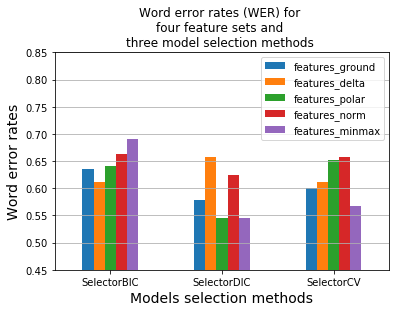

In [43]:
ax = df.plot(kind="bar", ylim=(.45, .85), rot=0, 
        title='Word error rates (WER) for \nfour feature sets and \nthree model selection methods ')
ax.set_xlabel('Models selection methods', fontsize=14)
ax.set_ylabel('Word error rates', fontsize=14)
ax.yaxis.grid()

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

I have experimented with five features (ground, delta, polar, norm, and minmax) and three model selection methods combinations (BIC, DIC, and CV). The results from all 15 experiments are summarized in the figure above. The results of three combinations which achieved WER < 60% are retained in the cells above. Those three combinations are: *features_ground and DIC*, *features_polar and DIC*, and *features_custom and DIC*. The listed above combinations achieved 0.58, 0.55, and 0.55 WER respectively. It looks like that the Discriminative Information Criterion selection performs better than other selection techniques for most of the tested features. It is worth to mention that scaled features using a standard MinMax approach exhibit the best WERs in DIC and CV experiments and outperformed Z-score (standardization) normalized features. I believe that MinMax scaling is a good approach for ASL due to minimizing features variations due to different speaker’s position and size, and good for reducing outliers due to different motions for the same word showed by different speakers. 
The polar features also can be used in ASL with conditioning on using a DIC selector model. Generally speaking, the DIC trained on a corpus with the same speakers should be a good model due to the maximizing discrimination between the word of interest and the other words, but on the other hand, the cross validation might be better for the unseen speakers word recognition, moreover, the CV can be used with DIC, thus maximizing the model performance.

Some of the possible improvements without a lot of modifications and other complex computations can be done by changing features pre-processing technique and/or scoring function. Dimensionality reduction techniques like principal component analysis (PCA) or Latent Dirichlet Allocation (LDA) are commonly applied. LDA is often used in speech recognition to combine and reduce features, while maximizing the linear separability of the classes in the transformed feature space. ([Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf)). 

A statistical language model (SLM), (https://en.wikipedia.org/wiki/Language_model) a probability distribution over sequences of words model, can be used to improve word prediction base on the word neighbors (the relative likelihood of different phrases). The N-gram model (https://en.wikipedia.org/wiki/N-gram) gives a probability of the word given some history (a sequence of previous words). The Markov assumptions can be used to compute the word probabilities. Nowadays, N-gram models of different complexity are within the most important tools in speech and language processing (https://lagunita.stanford.edu/c4x/Engineering/CS-224N/asset/slp4.pdf).


<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [44]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 40.827s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [45]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-419.386159,17.145481,-301.138355,-82.953865,-278.142553,-76.252636,-504.999033,-912.500821,-335.844543,-400.460423,...,-559.098779,-84.921264,-357.480379,-219.594578,-49.534504,-403.618393,-827.260440,-327.826927,-297.664494,-122.427753
1,-1259.553849,-728.179523,-2469.467339,81.660159,-1729.821976,-19.356400,-317.997158,74.440628,37.573293,-117.480345,...,62.425446,-79.951972,-158.428714,-187.530943,-16.197334,-868.926191,-225.871441,-118.195865,70.598493,-220.622783
2,-1556.926321,-669.602080,-3819.895571,51.817349,-1864.723527,-66.261404,-720.023010,-250.709638,4.600198,-100.696021,...,75.678462,-168.135408,-369.345728,-228.597010,-14.138138,-1242.261877,-646.068498,-199.374498,-173.857220,-383.172970
3,-19.607443,-285.807355,-46.315171,-34.781893,32.266170,-7.872825,13.500974,-437.547891,-280.919867,-220.842035,...,-766.403819,91.123623,-387.412449,1.413437,-56.849113,11.691619,63.583479,107.730469,-448.491022,12.135253
4,-318.858693,-243.326828,-509.375836,18.391525,-513.409588,24.607270,-52.652649,-26.445086,-6.926309,18.067089,...,-12.778527,-4.530859,-11.549608,-10.851167,-17.229596,-238.822143,-43.128202,-41.664337,-10.191808,-44.114725
